Setup PyTorch to use best hardware option

In [1]:
import torch

torch.backends.cuda.matmul.allow_tf32 = True

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [2]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
train_df = pd.read_parquet("hf://datasets/jayavibhav/prompt-injection/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/jayavibhav/prompt-injection/" + splits["test"])

In [3]:
test_df.rename(columns={"text":"prompt"}, inplace=True)
train_df.rename(columns={"text":"prompt"}, inplace=True)

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=False, use_fast=True, max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# A utility function to receive a batch of data and tokenize the prompts
def tokenize_batch(batch):
    return tokenizer(batch['prompt'], padding="max_length", truncation=True, max_length=512)

In [6]:
# Tokenize prompts in both training and testing datasets
prompts_train_tokenized = tokenize_batch(train_df.to_dict(orient='list'))
prompts_test_tokenized = tokenize_batch(test_df.to_dict(orient='list'))

In [7]:
# Define a dataset Class to work with PyTorch's DataLoader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [8]:
train_dataset = CustomDataset(prompts_train_tokenized, train_df['label'])
test_dataset = CustomDataset(prompts_test_tokenized, test_df['label'])

In [9]:
# Import TrainingArguments to handle the various training configurations
from transformers import TrainingArguments

# Define training arguments for fine-tuning
# GPU NVIDIA RTX A6000
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./results/logs",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    tf32=True,
    num_train_epochs=3,
    torch_compile=True,
    load_best_model_at_end=True,
    dataloader_num_workers=4
)

In [10]:
# Initialize a DataFrame to track the model's performance
results_df = pd.DataFrame(columns=["epoch","accuracy","precision","recall","f1"])

In [11]:
# Import accuracy metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# A utility function for model evaluation during fine-tuning
def evaluate_model(trainer, epoch):
    
    # Extract predictions and labels
    predictions = trainer.predictions.argmax(axis=1)

    labels = trainer.label_ids
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate precision, recall, and f1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    
    # Append current metrics to results
    global results_df
    results_df.loc[len(results_df)] = [epoch, accuracy, precision, recall, f1]
        
    # Return
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [12]:
# Import the Trainer class
from transformers import Trainer

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: evaluate_model(p, trainer.state.epoch),
)

In [13]:
# Fine-tune the model
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.019900,0.016322,0.996331,0.996438,0.996129,0.996284
2,0.010100,0.018367,0.996820,0.998292,0.995262,0.996775
3,0.004600,0.016489,0.997034,0.998447,0.995541,0.996992


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=24540, training_loss=0.01529508409467575, metrics={'train_runtime': 13909.6525, 'train_samples_per_second': 56.451, 'train_steps_per_second': 1.764, 'total_flos': 2.0660218932794573e+17, 'train_loss': 0.01529508409467575, 'epoch': 3.0})

In [14]:
output_dir = "./training_results"
model.save_pretrained(output_dir + "/ms-deberta-v3-model")
tokenizer.save_pretrained(output_dir + "/ms-deberta-v3-tokenizer")

('./training_results/ms-deberta-v3-tokenizer/tokenizer_config.json',
 './training_results/ms-deberta-v3-tokenizer/special_tokens_map.json',
 './training_results/ms-deberta-v3-tokenizer/spm.model',
 './training_results/ms-deberta-v3-tokenizer/added_tokens.json',
 './training_results/ms-deberta-v3-tokenizer/tokenizer.json')

In [15]:
results_df

,epoch,accuracy,precision,recall,f1
0,1.0,0.996331,0.996438,0.996129,0.996284
1,2.0,0.996820,0.998292,0.995262,0.996775
2,3.0,0.997034,0.998447,0.995541,0.996992


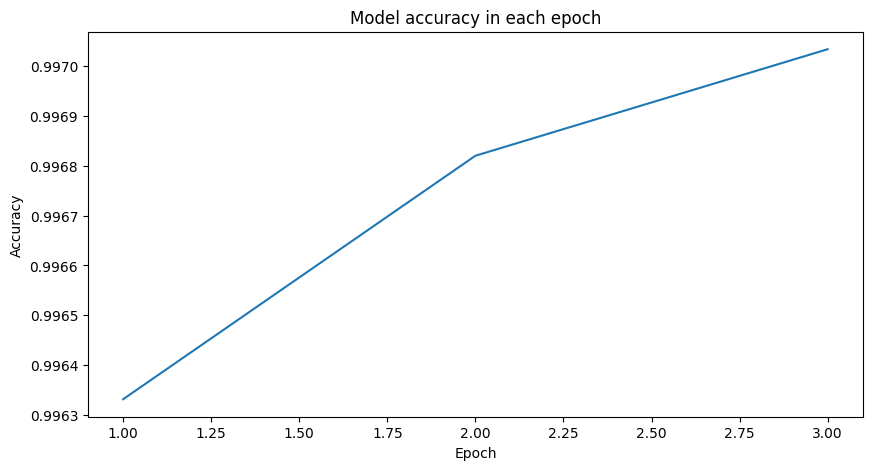

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the accuracy in each epoch

# Create a figure
plt.figure(figsize=(10,5))

# Plot samples
sns.lineplot(data=results_df, x="epoch", y="accuracy")

# Set figure title and axes labels
plt.title("Model accuracy in each epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

In [17]:
final_results = trainer.evaluate()
print(final_results)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'eval_loss': 0.016321714967489243, 'eval_accuracy': 0.9963311728017611, 'eval_precision': 0.9964378639573783, 'eval_recall': 0.9961293119464916, 'eval_f1': 0.9962835640620645, 'eval_runtime': 597.2736, 'eval_samples_per_second': 109.524, 'eval_steps_per_second': 3.424, 'epoch': 3.0}


In [18]:
output_dir = "./final_results"
model.save_pretrained(output_dir + "/ms-deberta-v3-model")
tokenizer.save_pretrained(output_dir + "/ms-deberta-v3-tokenizer")

('./final_results/ms-deberta-v3-tokenizer/tokenizer_config.json',
 './final_results/ms-deberta-v3-tokenizer/special_tokens_map.json',
 './final_results/ms-deberta-v3-tokenizer/spm.model',
 './final_results/ms-deberta-v3-tokenizer/added_tokens.json',
 './final_results/ms-deberta-v3-tokenizer/tokenizer.json')